# <center> <ins> Quantitative Trading & Analysis Group Project</ins>

**Group Members:**
* Aditya Bhandare
* VS Chaitanya Madduri
* Rebecca Meier
* Sammir LeSage

**Table of Contents**
1. [Library Imports](#--1.-Library-Imports)
2. [Data Preparation](#2-data-preparation)
3. [Benchmark Portfolio](#3-creating-the-benchmark-portfolio)
4. [Backtesting class](#4-Backtesting:)

#### Summary of Findings:

The goal of this project was to improve the performance of a subset of 50 stocks of the SP500 universe using option implied signals. 

We first calculated the benchmark portfolio `df_bm` using a value-weighted, or market-cap weighted, portfolio comprising these 50 stocks from 01/2000 until 12/2021.
The training period was constrained between 01/2000 - 12/2015, with the testing period then being 01/2016 - 12/2021. In addition, several constrains were imposed on the models, such as factor exposure deviation maximum of 0.05, a weight deviation for each asset with a max of 10% of the benchmark weight, and a 1% drawdown constraint relative to the benchmark per month.

Following these constraints, we selected the best performing model during the training period on the basis of Sharpe Ratio and Excess Return with respect to the benchmark, `df_bm`. We found that the `MSR_GrammSchmidt` performed the best, with a Sharpe Ratio of **0.631** and overall returns at **177.8%** during the training period and subsequent Sharpe Ratio of **1.156** and roughly **29%** Excess Return with respect to the benchmark portfolio during the testing period. 


The following table is a summary of our top three results based on the training Sharpe Ratio.


| Method           | Training SR | Training Returns | Testing SR | Testing Returns|
|------------------|-------------|---------------|----------|--------------|
| MVP_LGBM         | 0.589     | 158.7 %     | 1.245    |127.8 %         |
| MSR_GrammSchmidt | 0.631    | 177.8 %     | 1.156    |121.5 %        |

## <center> 1. Library Imports

In [1]:
# after we install all the packages, import all of them for the use in today's lecture!
import platform
my_system = platform.uname()
print(f'My PC node: {my_system.node.lower()}')

# General purpose libraries
import pandas as pd
import numpy as np
import time
from IPython.display import clear_output
import joblib
import datetime
from pathlib import Path
import os
import warnings
warnings.filterwarnings("ignore")

# Storage operations, Database access:
import pandas_datareader as web
import quandl as quandl
import wrds as wrds
import requests
from io import BytesIO
from zipfile import ZipFile

# Data visualization:
import quantstats as qs
import matplotlib.pyplot as plt
import seaborn as sns 

# Data processing libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MaxAbsScaler, PowerTransformer, MinMaxScaler, QuantileTransformer, RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin, clone
import statsmodels.api as sm
import linearmodels as lm
from scipy.optimize import minimize
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn import metrics
import matplotlib.ticker as mtick
from scipy import stats 
from joblib import Parallel, delayed
import multiprocessing
from multiprocessing import Pool, cpu_count

if cpu_count() > 30:
    CPUUsed = 15
else:
    CPUUsed = cpu_count() - 2

# we can specify some options depending on your computer
class Options:
    path = Path('./temp')
    if (my_system.node.lower()[0:14] == 'fs-mac-fcy-040'): # GREG'S MACHINE - do not change please
        wrds_name = 'gvfs'
    elif (my_system.node.lower() == 'desktop-m5gaseo'):
        wrds_name = 'slesageq'
        pass
    elif (my_system.node.lower() == 'laptop-sfpkifct'):
        wrds_name = 'b4241523'
        pass
    elif (my_system.node.lower() == 'pop-os'):
        wrds_name = 'adityabhandare'
        pass

# some file names
class FileNames:
    fn_csv_factors   = Options.path / 'ff_fact.csv'
    fn_excel_factors = Options.path / 'ff_fact.xls'

    fn_crsp     = Options.path / 'crsp.h5'
    key_crsp_daily = 'daily'

    fn_stock_features_labels = Options.path / 'stock_features.h5'
    key_features_crsp = 'crsp'

    fn_stock_features_om = Options.path / 'stock_features_om.h5'
    key_features_om = 'om'

    fn_ff_factors    = Options.path / 'ff_factors.h5'
    key_ff_daily = 'ff_daily'

    fn_sp500comp = Options.path / 'SP500_Index_Constitutes2020.csv'
    fn_sp500comp_url = "https://www.dropbox.com/sh/07axrrdnpk1mgww/AABP97iMFVQeieiyoeO6naMFa/SP500_Index_Constitutes2020.csv?dl=1"
    fn_id_link = Options.path / 'daily_permno_secid_cusip_link.csv'
    fn_id_link_url = "https://www.dropbox.com/sh/07axrrdnpk1mgww/AABQsPXiRAmwUW1TQNfuBfd4a/daily_permno_secid_cusip_link.csv?dl=1"
    fn_universe = Options.path / 'permno_selection.csv'
    fn_universe_url = "https://www.dropbox.com/sh/07axrrdnpk1mgww/AACgSLnag6gXPk3vX1xlaAE2a/permno_selection.csv?dl=1"

    # GLB data
    glb_url  = "https://osf.io/download/g8mq5/"
    glb_daily = Options.path / 'glb_daily.csv'

    # Option implied data:
    bv_betas = "https://osf.io/download/6vsf4/"

# Define function to open zip files from the web:
def get_zip(file_url):
    url = requests.get(file_url)
    zipfile = ZipFile(BytesIO(url.content))
    files = [zipfile.open(file_name) for file_name in zipfile.namelist()]
    return files.pop() if len(files) == 1 else files

# Check if the folder is already present
isExist = os.path.exists(Options.path)
if not isExist:

   # if it doesn't exist, create the folder
   os.makedirs(Options.path)
   print("The new directory is created!")

print(f'Paths set. data root is in {Options.path}')

My PC node: pop-os
Paths set. data root is in temp


## <center> 2. Data Preparation

Functions to load data:

In [2]:
# Functions to Load Data
def load_ff_crsp():
    crsp = pd.read_hdf(FileNames.fn_crsp, key = FileNames.key_crsp_daily)
    ff = pd.read_hdf(FileNames.fn_ff_factors, key = FileNames.key_ff_daily)
    return crsp, ff

def load_features(type):
    if type == 'crsp':
        return pd.read_hdf(FileNames.fn_stock_features_labels, key = FileNames.key_features_crsp)
    elif type == 'om':
        return pd.read_hdf(FileNames.fn_stock_features_om, key = FileNames.key_features_om)
    else:
        print('type not supported')

Functions to download data from wrds:

In [3]:
def prepare_save_rets(load_factors = True, factors_from = 1999,
                     load_crsp_data = True, crsp_from = 1999,
                     restrict_universe = True):
    import time

    UNIVERSE_PERMNO = ''
    UNIVERSE_SECID = ''
    if restrict_universe:
        # read the sp500 composition and make the string from PERMNO for SQL
        comp = pd.read_csv(FileNames.fn_sp500comp_url)
        comp['start']  = pd.to_datetime(comp['start'])
        comp['ending'] = pd.to_datetime(comp['ending'])
        comp = comp.loc[comp.ending>'1998',:]
        universe_permno = tuple(universe)
        UNIVERSE_PERMNO = f'AND a.permno in {universe_permno}'

        id_link = pd.read_csv(FileNames.fn_id_link_url)
        universe_secid = tuple(id_link[id_link.date>=str(1999)].secid)
        UNIVERSE_SECID = f'AND a.secid in {universe_secid}'
        pass

    if load_factors:
        startdt = datetime.datetime(factors_from,1,1)

        d1 = web.DataReader('F-F_Research_Data_Factors_daily','famafrench',start=startdt)
        d2 = web.DataReader('F-F_Momentum_Factor_daily','famafrench',start=startdt)
        d3 = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily','famafrench',start=startdt)

        ff = d1[0]/100
        ff = ff.join(d2[0]/100, how = 'left')
        ff5 = d3[0]/100
        ff = ff.join(ff5.loc[:,['RMW','CMA']], how = 'left')

        ff.columns = [z.lower().strip() for z in ff.columns]
        ff.rename(columns = {'mkt-rf':'mktrf'}, inplace = True)

        ff = ff.loc[:,['mktrf', 'smb', 'hml', 'mom', 'rmw', 'cma','rf']]
        ff.to_hdf(FileNames.fn_ff_factors, key = FileNames.key_ff_daily, mode = 'w')

        print(f'Saved FF factors')
        pass

    if load_crsp_data:

        # get the data!
        db = wrds.Connection(wrds_username=Options.wrds_name)
        
        start = time.time()
        
        data_crsp = pd.DataFrame()
        for YR in range(crsp_from,2022):
            
            sql_wrds = f"""
            select distinct a.date, a.permno, a.cusip, a.ret, abs(a.prc) as prc, a.shrout, abs(a.prc)*a.shrout/1000 as mktcap, a.vol
            from crsp.dsf as a
            where
            EXTRACT(YEAR FROM a.date) = {YR}
            {UNIVERSE_PERMNO}
            ORDER BY a.permno, a.date
            """
            data_crsp = pd.concat([data_crsp,db.raw_sql(sql_wrds)], axis = 0)
            print(f'finished downloading CRSP {YR} in {(time.time()-start)/60:.2f} minutes')
            pass
        
        data_crsp['date'] = pd.to_datetime(data_crsp['date'])
        db.close()

        data_crsp = data_crsp.sort_values(by = ['permno','date'])
        data_crsp['mktcap'] = data_crsp.groupby(['permno'])['mktcap'].shift(1)
        data_crsp['vw'] = data_crsp['mktcap']/data_crsp.groupby(['date'])['mktcap'].transform('sum')

        data_crsp.to_hdf(FileNames.fn_crsp, key = FileNames.key_crsp_daily, mode = 'w')
        print(f'Saved CRSP data')
        pass
    pass
 
# define functions to load data
def get_beta_bypermno(df, permno=None, window=252, min_n=int(252/2), factor_model='ff4'):

    if (permno is not None) and (permno in df.columns): 
        df = df.rename(columns={permno: 'ret'})
    else:
        print(f'permno {permno} not in the data')        
    if factor_model == 'capm':
        formula = f'ret ~ 1 +  mktrf'
    elif factor_model == 'ff3':
        formula = f'ret ~ 1 +  mktrf + smb + hml'
    elif factor_model == 'ff4':
        formula = f'ret ~ 1 +  mktrf + smb + hml + mom'
    elif factor_model == 'ff5':
        formula = f'ret ~ 1 +  mktrf + smb + hml + rmw + cma'
    else:
        formula = f'ret ~ 1'
        pass

    try:
        rres = RollingOLS.from_formula(formula, 
                                       data=df, 
                                       window=window, 
                                       min_nobs=min_n,
                                       missing='drop').fit(params_only=False)
        temp_beta = rres.params.iloc[:,1:]
        temp_beta.columns = [f'beta_{z}' for z in temp_beta.columns]
        temp_beta = temp_beta.join((rres.mse_resid.to_frame(f'idvar_{factor_model}')*252))
        temp_beta['permno'] = permno
        temp_beta = temp_beta.dropna(axis=1, how ='all')
        return temp_beta.reset_index()
    except:
        pass
    pass

def compute_features_labels(data, 
                            ff,
                            factor_model = 'ff4',
                            SaveResults = True):
    
    res_dict = {}
    
    cols2use = ['permno','date','ret','mktcap']
    data0 = data.reset_index()[cols2use].copy()
    data0.sort_values(by = ['permno','date'], inplace = True)

    # let us compute 1-day return by groups
    data0['fret1d'] = data0.groupby(by=['permno'])['ret'].shift(-1)

    # let us compute 5-day forward return
    fn_5dret = lambda x: np.exp(x.rolling(window=5, min_periods=3).sum())-1

    data0['lret'] = np.log(1+data0['ret'])
    data0['fret5d'] = data0.\
                        groupby(by=['permno'], group_keys=True)['lret'].\
                        apply(fn_5dret).shift(-5).values
    
    # forward returns 
    print('Computed forward returns')
    frets = {'frets':['fret1d','fret5d']}
    res_dict.update(frets)

    # momentum/ reversal can be defined in a number of ways, 
    #e.g. momentum = total return from months - 13 to -1:
    fn_mom12m = lambda x: np.exp(x.rolling(window=252, min_periods=63).sum())-1
    #e.g. momentum = total return from months - 7 to -1:
    fn_mom6m = lambda x: np.exp(x.rolling(window=126, min_periods=31).sum())-1
    #e.g. reversal = total return for past month:
    fn_rev = lambda x: np.exp(x.rolling(window=21, min_periods=15).sum())-1


    data0['mom12m'] = data0.\
                        groupby(by=['permno'], group_keys=True)['lret'].\
                        apply(fn_mom12m).shift(22).values

    data0['mom6m'] = data0.\
                        groupby(by=['permno'], group_keys=True)['lret'].\
                        apply(fn_mom6m).shift(22).values

    data0['rev1m'] = data0.\
                        groupby(by=['permno'], group_keys=True)['lret'].\
                        apply(fn_rev).values
    
    data0.drop(columns = ['lret'], inplace = True)
    # mom_rev 
    print('Computed momentum/ reversal')
    momrev = {'momrev':['mom12m','mom6m','rev1m']}
    res_dict.update(momrev)
    
    
    # factor betas 
    # create a slimmer copy for work 
    cols2use = ['permno','date','ret']
    data1 = data0[cols2use].copy().set_index(['date','permno']).sort_index()

    df_ret = data1['ret'].unstack()
    universe = list(df_ret.columns)

    # subtract risk-free rate from returns to get excess returns 
    idx = df_ret.index
    df_ret = df_ret.subtract(ff.loc[idx,'rf'], axis=0)

    # merge to include factors 
    factors = ['mktrf','smb','hml','mom','rmw','cma']
    df_ret = df_ret.merge(ff.loc[idx,factors], on = 'date')
    
    with Parallel(n_jobs=CPUUsed) as parallel:
        res = parallel(delayed(get_beta_bypermno)(df_ret[[permno, *factors]],
                                          permno,
                                          window = 252,
                                          min_n = 126,
                                          factor_model = factor_model) for permno in universe)
        pass
    
    temp = pd.concat(res)
    temp = temp.set_index(['permno','date']).sort_index().dropna()
    
    ##
    print('Computed factor betas')
    facts = {'fmodels':list(temp.columns)}
    res_dict.update(facts)
    
    data0 = data0.set_index(['permno','date'])
    
    data0 = data0.merge(temp, on = ['permno','date'])
    
    if SaveResults:
        data0.to_hdf(FileNames.fn_stock_features_labels, key= FileNames.key_features_crsp, mode = 'w')
        pass

    return data0, res_dict

Downloading CRSP Data:

In [4]:
# Loading the CRSP data for the 50 selected stocks from 1999 onwards:
universe = list(pd.read_csv(FileNames.fn_universe_url).permno)

prepare_save_rets(load_factors = True, factors_from = 1999,
                     load_crsp_data = True, crsp_from = 1999,
                     restrict_universe = True)

crsp, ff = load_ff_crsp()

# # computing the beta by permno for each file
res, res_dict = compute_features_labels(data = crsp, 
                            ff = ff,
                            factor_model = 'ff4',
                            SaveResults = True)

Saved FF factors
Loading library list...
Done
finished downloading CRSP 1999 in 0.02 minutes
finished downloading CRSP 2000 in 0.02 minutes
finished downloading CRSP 2001 in 0.03 minutes
finished downloading CRSP 2002 in 0.03 minutes
finished downloading CRSP 2003 in 0.04 minutes
finished downloading CRSP 2004 in 0.04 minutes
finished downloading CRSP 2005 in 0.05 minutes
finished downloading CRSP 2006 in 0.05 minutes
finished downloading CRSP 2007 in 0.05 minutes
finished downloading CRSP 2008 in 0.06 minutes
finished downloading CRSP 2009 in 0.06 minutes
finished downloading CRSP 2010 in 0.07 minutes
finished downloading CRSP 2011 in 0.08 minutes
finished downloading CRSP 2012 in 0.08 minutes
finished downloading CRSP 2013 in 0.08 minutes
finished downloading CRSP 2014 in 0.09 minutes
finished downloading CRSP 2015 in 0.09 minutes
finished downloading CRSP 2016 in 0.10 minutes
finished downloading CRSP 2017 in 0.10 minutes
finished downloading CRSP 2018 in 0.11 minutes
finished downl

In [5]:
print("The number of unique permnos in CRSP dataset are: {}".format(len(crsp.permno.unique())))
print("The number of unique permnos in res dataset are: {}".format(len(res.index.get_level_values("permno").unique())))

The number of unique permnos in CRSP dataset are: 50
The number of unique permnos in res dataset are: 50


Function to download Option Metrics data:

In [6]:
def prepare_save_om(load_om_data = True, 
                    om_from = 1999, 
                    om_to = 2021,
                    restrict_universe = True):
    

    UNIVERSE_PERMNO = ''
    UNIVERSE_SECID = ''
    
    # read link in any case -- need later for merging 
    id_link = pd.read_csv(FileNames.fn_id_link_url)
    id_link['date']  = pd.to_datetime(id_link['date'])
    if restrict_universe:
        # read the sp500 composition and make the string from PERMNO for SQL
        comp = pd.read_csv(FileNames.fn_sp500comp_url)
        comp['start']  = pd.to_datetime(comp['start'])
        comp['ending'] = pd.to_datetime(comp['ending'])
        comp = comp.loc[comp.ending>'1999',:]
        universe_permno = tuple(universe)
        UNIVERSE_PERMNO = f'AND a.permno in {universe_permno}'

        goods = id_link.permno.isin(universe_permno)
        universe_secid = tuple(id_link.loc[goods,'secid'].dropna().unique())
        
        UNIVERSE_SECID = f'AND secid in {universe_secid}'
        pass

    if load_om_data:
        
        db = wrds.Connection(wrds_username=Options.wrds_name)
        
        start = time.time()
        
        data_om = pd.DataFrame()
        for YR in range(om_from, om_to+1):
        
            sql_wrds = f'''

            select a.date, a.secid,
            a.iv_atm as iv_atm,
            b.iv_otmput-a.iv_atm as put_skew,
            c.iv_otmcall-a.iv_atm as call_skew,
            c.iv_otmcall-b.iv_otmput as skew from

            (select date, secid, AVG(impl_volatility) as iv_atm
            from optionm.vsurfd{YR}
            where days = 30 and abs(delta)=50
            {UNIVERSE_SECID}
            group by date, secid) as a,

            (select date, secid, AVG(impl_volatility) as iv_otmput
            from optionm.vsurfd{YR}
            where days = 30 and delta >=-20 and delta<=-10 
            {UNIVERSE_SECID}
            group by date, secid) as b,
            
            (select date, secid, AVG(impl_volatility) as iv_otmcall
            from optionm.vsurfd{YR}
            where days = 30 and delta >=10 and delta <=20
            {UNIVERSE_SECID}
            group by date, secid) as c

            where a.date= b.date and a.secid = b.secid
            and a.date = c.date and a.secid = c.secid
            
            '''
            try:
                data_om = pd.concat([data_om,db.raw_sql(sql_wrds)], axis = 0)
                print(f'finished downloading OM {YR} in {(time.time()-start)/60:.2f} minutes')
                pass
            except: 
                pass
            
        db.close()
        data_om.loc[:,'date'] = pd.to_datetime(data_om.loc[:,'date'])
        
        # merge with PERMNO to have the same identified as in the other tables
        data_om = data_om.merge(id_link[['date','permno','secid']], how = 'left', on = ['date','secid'])
        data_om = data_om.set_index(["permno","date"]).sort_index()
        
        data_om.to_hdf(FileNames.fn_stock_features_om, key = FileNames.key_features_om, mode = 'w')
        print(f'Saved OM data')

    return 0

In [7]:
# Downloading the option metrics data
prepare_save_om()

Loading library list...
Done
finished downloading OM 1999 in 0.02 minutes
finished downloading OM 2000 in 0.04 minutes
finished downloading OM 2001 in 0.07 minutes
finished downloading OM 2002 in 0.09 minutes
finished downloading OM 2003 in 0.11 minutes
finished downloading OM 2004 in 0.13 minutes
finished downloading OM 2005 in 0.15 minutes
finished downloading OM 2006 in 0.17 minutes
finished downloading OM 2007 in 0.18 minutes
finished downloading OM 2008 in 0.20 minutes
finished downloading OM 2009 in 0.22 minutes
finished downloading OM 2010 in 0.24 minutes
finished downloading OM 2011 in 0.26 minutes
finished downloading OM 2012 in 0.28 minutes
finished downloading OM 2013 in 0.30 minutes
finished downloading OM 2014 in 0.32 minutes
finished downloading OM 2015 in 0.33 minutes
finished downloading OM 2016 in 0.35 minutes
finished downloading OM 2017 in 0.37 minutes
finished downloading OM 2018 in 0.39 minutes
finished downloading OM 2019 in 0.41 minutes
finished downloading OM 20

0

In [8]:
# Functions to Plot Data
def dist_plot(df1):
    sns.kdeplot(df1,
                fill = True,
                label = "Returns", color ="green")
    plt.legend(loc = "upper right")
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    pass

def plot_hist(df1, df2, column_name):
    # creating axes to draw plots
    fig, ax = plt.subplots(1, 2)

    # plotting the original data(non-normal) and
    # fitted data (normal)
    sns.kdeplot(df1[column_name],
                fill = True,
                #hist = False, kde = True,
                # kde_kws = {'shade': True, 'linewidth': 2},
                label = "Non-Normal", color ="green", ax = ax[0])

    sns.kdeplot(df2[column_name], #hist = False, kde = True,
                fill = True,
                # kde_kws = {'shade': True, 'linewidth': 2},
                label = "Normal", color ="green", ax = ax[1])

    # adding legends to the subplots
    plt.legend(loc = "upper right")

    # rescaling the subplots
    fig.set_figheight(5)
    fig.set_figwidth(10)
    pass

def return_stats(results_df,benchmark_df = None, title = None):
    import matplotlib.ticker as mtick
    # provide a different benchmark to compare against
    if benchmark_df is not None:
        results_df["Benchmark"] = benchmark_df.ret_bm-1

    results_df["Benchmark"] = df_bm.ret_bm-1
    sharpe_ratios = results_df.mean()/results_df.std()*np.sqrt(252)
    
    return(pd.concat([results_df.sum().rename("Total Returns"),\
                      (results_df.mean()/results_df.std()*np.sqrt(252)).rename("Sharpe Ratio")],axis=1))


def plot_returns(results_df,benchmark_df = None, title = None):
    import matplotlib.ticker as mtick
    # provide a different benchmark to compare against
    if benchmark_df is not None:
        results_df["Benchmark"] = benchmark_df.ret_bm-1

    results_df["Benchmark"] = df_bm.ret_bm-1
    sharpe_ratios = results_df.mean()/results_df.std()*np.sqrt(252)
    
    # Let's plot the graph
    plt.title(title if title != None else 'Performance of the strategy')
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    plt.grid(axis="x")
    plt.legend(list(results_df.columns), loc = 'upper left')
    plt.plot(results_df.dropna().cumsum())

def print_results(df):
    # descriptive stats of performance
    for col in df.columns:
        print('Analysis of the result for configuration: ' + col)
        ret = df[col].dropna()
        ret.cumsum().plot()
        print('Sharpe ratio = ' + str(df[col].mean()/df[col].std()*np.sqrt(252)))
        print('Annual return = ' + str(df[col].sum()))
        print('Average daily return (bps)= ' + str(df[col].mean()* 1e4))
        qs.reports.full(df[col])
        print('****************************************')

# Parsing Functions
def parse_features(df, feature_names, level_winsorize = 0.01):
    df = df.copy().dropna()
    for ft in feature_names:
        # winsorise
        df[ft] = winsorize(df[ft], limits=level_winsorize, nan_policy='omit').data

        # apply cox-box transform
        var_norm, lambda_ = stats.boxcox(df[ft] - df[ft].min() + 0.0001)
        if lambda_ < 5:
            #print(ft + ': optimal lambda = ' + str(lambda_))
            df[ft] = var_norm
        else:
            print(ft + ' procedure failed, skipping cox box transformation')
        #apply z-score scaling
        df[ft] = (df[ft] - df[ft].mean())  / df[ft].abs().max()
    return df

class Winsorize(BaseEstimator, TransformerMixin):
    feature_names = None
    level_winsorize = None
  # add another additional parameter, just for fun, while we are at it
    def __init__(self, feature_names = None, level_winsorize = 0.01):
#         print('\n>>>>>>>init() called.\n')
        self.feature_names = feature_names
        self.level_winsorize = level_winsorize
        self.abs_level_winsorize = {}

    def fit(self, X, y = None):
#         print('>>>>>>>fit() called.')
        X_ = X.copy() # creating a copy to avoid changes to original dataset
        self.feature_names = X_.columns if self.feature_names is None else self.feature_names
        for ft in self.feature_names:
            temp = winsorize(X_.loc[:,ft], limits=self.level_winsorize, nan_policy='omit').data
            self.abs_level_winsorize.update({ft:(np.nanmin(temp), np.nanmax(temp))})
            pass
        # print(f'level:{self.level_winsorize}\n')
        # print(f'abs levels: {self.abs_level_winsorize}\n')
        return self

    def transform(self, X, y = None):
#         print('\n>>>>>>>transform() called.\n')
        X_ = X.copy() # creating a copy to avoid changes to original dataset
        for ft in self.feature_names:
            if ft in X_.columns:
                lims = self.abs_level_winsorize[ft]
                tail_left = X_[ft]<=lims[0]
                tail_right = X_[ft]>=lims[1]
                X_.loc[tail_left, ft] = lims[0]
                X_.loc[tail_right, ft] = lims[1]
            else:
                print(f'Warning: {ft} not in the list of variables/ skipping')
            pass
        return X_

In [9]:
res.head()
data_om = load_features("om")
data_om.head()

secid    iv_atm  put_skew  call_skew      skew
permno  date                                                         
10874.0 1999-01-04  102386.0  0.399343  0.014970  -0.029862 -0.044832
        1999-01-05  102386.0  0.388733  0.012728  -0.011676 -0.024403
        1999-01-06  102386.0  0.398166  0.001265  -0.011411 -0.012676
        1999-01-07  102386.0  0.399320 -0.007250   0.000397  0.007647
        1999-01-08  102386.0  0.397845  0.010500  -0.021085 -0.031586

In [10]:
### Number of unique stocks in the previously stored options data
print("Number of unique stocks in the Option Data is {}".format\
      (len(data_om[data_om.index.get_level_values("permno").isin(universe)].index.get_level_values("permno").unique())))

Number of unique stocks in the Option Data is 50


In [11]:
# Merging the data:
res_ = res.copy().reset_index()
data_om_ = data_om.copy().reset_index()
df = pd.merge(res_, data_om_, how="inner")
df = df.set_index(['permno', 'date']).sort_index()

In [12]:
### Number of unique stocks in the previously stored options data
print("Number of unique stocks in the all the features Data is {}".format\
      (len(df[df.index.get_level_values("permno").isin(universe)].index.get_level_values("permno").unique())))
df.head()

Number of unique stocks in the all the features Data is 50


ret       mktcap    fret1d    fret5d    mom12m  \
permno  date                                                              
10874.0 1999-12-31 -0.011111  2066.107500 -0.014045 -0.039326 -0.099618   
        2000-01-03 -0.014045  2043.150750 -0.045584 -0.022792 -0.109937   
        2000-01-04 -0.045584  2014.454812  0.005970  0.023881 -0.107357   
        2000-01-05  0.005970  1922.627812  0.008902  0.014837 -0.112517   
        2000-01-06  0.008902  1934.106188  0.005882  0.014706 -0.115097   

                       mom6m     rev1m  beta_mktrf  beta_smb  beta_hml  \
permno  date                                                             
10874.0 1999-12-31 -0.057281  0.031884    0.998254  0.764682  0.404181   
        2000-01-03 -0.080380  0.014451    1.032156  0.784538  0.414427   
        2000-01-04 -0.099108 -0.026163    1.079493  0.830231  0.437168   
        2000-01-05 -0.115711 -0.017493    1.113169  0.829421  0.402571   
        2000-01-06 -0.099960  0.017964    1.113622  0.839856  0.356142   

                    beta_mom  idvar_ff4     secid    iv_atm  put_skew  \
permno  date                                                            
10874.0 1999-12-31 -0.673465   0.149743  102386.0  0.378777  0.006904   
        2000-01-03 -0.746982   0.146484  102386.0  0.372216  0.009612   
        2000-01-04 -0.727018   0.147118  102386.0  0.379116  0.004660   
        2000-01-05 -0.801960   0.146055  102386.0  0.375619 -0.001124   
        2000-01-06 -0.855652   0.144450  102386.0  0.376987 -0.003913   

                    call_skew      skew  
permno  date                             
10874.0 1999-12-31   0.014340  0.007435  
        2000-01-03   0.027117  0.017505  
        2000-01-04   0.007030  0.002370  
        2000-01-05  -0.003685 -0.002562  
        2000-01-06   0.016416  0.020329

Merging with GLB data

In [13]:
# Importing and cleaning the GLB file:
glb = pd.read_csv(get_zip(FileNames.glb_url))
glb.rename({'id':'permno'}, axis=1, inplace=True)
glb['date'] = pd.to_datetime(glb['date'])
glb = glb.set_index(['permno', 'date']).sort_index()
glb.head()

glb2_D30  glb3_D30  glb2_D91  glb3_D91  glb2_D182  \
permno  date                                                            
10078.0 1996-01-04  0.068033  0.067927  0.057906  0.057766   0.050746   
        1996-01-05  0.068033  0.067927  0.057906  0.057766   0.050746   
        1996-01-08  0.068033  0.067927  0.057906  0.057766   0.050746   
        1996-01-09  0.068033  0.067927  0.057906  0.057766   0.050746   
        1996-01-10  0.068033  0.067927  0.057906  0.057766   0.050746   

                    glb3_D182  glb2_D273  glb3_D273  glb2_D365  glb3_D365  
permno  date                                                               
10078.0 1996-01-04   0.050633   0.050788   0.050661   0.050624   0.050577  
        1996-01-05   0.050633   0.050788   0.050661   0.050624   0.050577  
        1996-01-08   0.050633   0.050788   0.050661   0.050624   0.050577  
        1996-01-09   0.050633   0.050788   0.050661   0.050624   0.050577  
        1996-01-10   0.050633   0.050788   0.050661   0.050624   0.050577

Let's try adding option implied correlation data:

In [14]:
# bv_betas = pd.read_csv(get_zip(FileNames.bv_betas))
# bv_betas.rename({'id':'permno'}, axis=1, inplace=True)
# bv_betas['date'] = pd.to_datetime(bv_betas['date'])
# bv_betas = bv_betas.set_index(['permno', 'date']).sort_index()
# bv_betas.head()

Merging all the collected data into a final dataframe:

In [15]:
# Merging all the data:
final = df.merge(glb, how='inner', on=['permno', 'date'])
# final = final.merge(bv_betas, how='left', on=['permno', 'date'])
# Sanity check:
print("Number of unique stocks in final dataframe is {}".format\
      (len(final[final.index.get_level_values("permno").isin(universe)].index.get_level_values("permno").unique())))

final.to_hdf(Options.path/"final.h5", key='df', mode='w')

Number of unique stocks in final dataframe is 50


### Loading the previously saved hdf file:

In [16]:
df = pd.read_hdf(Options.path/"final.h5",key="df")
df.dropna(inplace = True)
df['constant'] = 1.0
# Column for beta constraint:
df['betas'] = df['beta_mktrf']
df

ret        mktcap    fret1d    fret5d    mom12m  \
permno  date                                                               
10874.0 2004-04-05  0.013269   3883.782171 -0.002619 -0.021905  1.199157   
        2004-04-06 -0.002619   3935.316000 -0.003581 -0.006923  1.219418   
        2004-04-07 -0.003581   3925.009163 -0.014854  0.004791  1.263542   
        2004-04-08 -0.014854   3910.954677  0.017510  0.034776  1.352782   
        2004-04-12  0.017510   3852.861660 -0.018164  0.014579  1.390541   
...                      ...           ...       ...       ...       ...   
88664.0 2021-11-12 -0.009233  11788.068107 -0.004691 -0.028718  0.029657   
        2021-11-15 -0.004691  11679.227747  0.004076 -0.024331  0.055661   
        2021-11-16  0.004076  11624.437000 -0.024359 -0.029180  0.059646   
        2021-11-17 -0.024359  11671.823195 -0.013004 -0.006437  0.066143   
        2021-11-18 -0.013004  11387.506026  0.009289 -0.004348  0.093763   

                       mom6m     rev1m  beta_mktrf  beta_smb  beta_hml  ...  \
permno  date                                                            ...   
10874.0 2004-04-05  0.442925  0.067887    0.929207  0.021911  0.135846  ...   
        2004-04-06  0.429375  0.039712    0.927334  0.000899  0.078156  ...   
        2004-04-07  0.462696  0.010654    0.924014 -0.019639  0.076406  ...   
        2004-04-08  0.483999 -0.000486    0.921625 -0.003121  0.085215  ...   
        2004-04-12  0.491957  0.064090    0.924204 -0.002850  0.064028  ...   
...                      ...       ...         ...       ...       ...  ...   
88664.0 2021-11-12  0.059887 -0.060960    0.836499 -0.439657  0.007731  ...   
        2021-11-15  0.063485 -0.076796    0.836389 -0.436316  0.005635  ...   
        2021-11-16  0.061220 -0.078398    0.871926 -0.411568  0.007264  ...   
        2021-11-17  0.049809 -0.100322    0.881072 -0.406322  0.008678  ...   
        2021-11-18  0.035045 -0.112696    0.889982 -0.397461  0.005551  ...   

                    glb2_D91  glb3_D91  glb2_D182  glb3_D182  glb2_D273  \
permno  date                                                              
10874.0 2004-04-05  0.050650  0.050673   0.035364   0.035381   0.030965   
        2004-04-06  0.052306  0.052330   0.036417   0.036435   0.032837   
        2004-04-07  0.052088  0.052112   0.038584   0.038603   0.036476   
        2004-04-08  0.054256  0.054281   0.039548   0.039567   0.037078   
        2004-04-12  0.050045  0.050068   0.037018   0.037035   0.036137   
...                      ...       ...        ...        ...        ...   
88664.0 2021-11-12  0.030492  0.030513   0.032686   0.032709   0.031535   
        2021-11-15  0.033988  0.034012   0.032266   0.032290   0.031269   
        2021-11-16  0.033065  0.033088   0.032122   0.032145   0.030661   
        2021-11-17  0.036348  0.036373   0.032965   0.032988   0.031899   
        2021-11-18  0.031643  0.031665   0.033014   0.033038   0.030509   

                    glb3_D273  glb2_D365  glb3_D365  constant     betas  
permno  date                                                             
10874.0 2004-04-05   0.030980   0.030565   0.030580       1.0  0.929207  
        2004-04-06   0.032853   0.032469   0.032485       1.0  0.927334  
        2004-04-07   0.036494   0.036289   0.036306       1.0  0.924014  
        2004-04-08   0.037096   0.036818   0.036835       1.0  0.921625  
        2004-04-12   0.036154   0.036258   0.036275       1.0  0.924204  
...                       ...        ...        ...       ...       ...  
88664.0 2021-11-12   0.031557   0.030056   0.030078       1.0  0.836499  
        2021-11-15   0.031292   0.030699   0.030722       1.0  0.836389  
        2021-11-16   0.030683   0.029713   0.029735       1.0  0.871926  
        2021-11-17   0.031921   0.031508   0.031530       1.0  0.881072  
        2021-11-18   0.030531   0.028448   0.028469       1.0  0.889982  

[201077 rows x 29 columns]

Defining the feature lists:

In [17]:
# define feature names -- initial selection
feature_names = ['mom12m',
                 'mom6m',
                 'rev1m',
                 'beta_mktrf',
                 'beta_smb',
                 'beta_hml',
                 'beta_mom',
                 'idvar_ff4',
                 'iv_atm',
                 'put_skew',
                 'call_skew', 
                 'skew']
# Defining features from the GLB data
features_glb = ['glb2_D30', 
                'glb3_D30', 
                'glb2_D91', 
                'glb3_D91', 
                'glb2_D182',       
                'glb3_D182', 
                'glb2_D273', 
                'glb3_D273', 
                'glb2_D365', 
                'glb3_D365']

#Defining features for Option implied correlation(bv_betas):
feature_bv_betas = ['bv_beta30',
                    'bv_beta91', 
                    'bv_beta182', 
                    'bv_beta273', 
                    'bv_beta365']



# we can define also some extra features, e.g.,
feature_for_sq = ['mom12m',
                 'mom6m',
                 'rev1m',
                 'beta_mktrf',
                 'beta_smb',
                 'beta_hml',
                 'beta_mom',
                 'iv_atm',
                 'put_skew',
                 'call_skew']



feature_sq = [f'{z}sq' for z in feature_for_sq]
df[feature_sq] = df[feature_for_sq]**2


feature_for_combos = [
                     'iv_atm',
                     'put_skew',
                     'call_skew']

from itertools import product, combinations

combos = list(combinations(feature_for_combos, 2))
feature_combo = ['_'.join(z) for z in combos]
df[feature_combo] = np.array([df[list(z)].product(axis=1).values for z in combos]).T

del combos



For a sanity check, let's inspect the columns created:

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 201077 entries, (10874.0, Timestamp('2004-04-05 00:00:00')) to (88664.0, Timestamp('2021-11-18 00:00:00'))
Data columns (total 42 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ret                 201077 non-null  float64
 1   mktcap              201077 non-null  float64
 2   fret1d              201077 non-null  float64
 3   fret5d              201077 non-null  float64
 4   mom12m              201077 non-null  float64
 5   mom6m               201077 non-null  float64
 6   rev1m               201077 non-null  float64
 7   beta_mktrf          201077 non-null  float64
 8   beta_smb            201077 non-null  float64
 9   beta_hml            201077 non-null  float64
 10  beta_mom            201077 non-null  float64
 11  idvar_ff4           201077 non-null  float64
 12  secid               201077 non-null  float64
 13  iv_atm              201077 non-null  float64
 14  put_s

## <center> 3. Creating the benchmark portfolio

In [19]:
#create value weighted portfolio
total_market_cap = df.groupby(by=['date'])['mktcap'].sum()

# divide the market_cap of each stock by the total market cap for its date
df['percentage_market_cap'] = df['mktcap'] / df.index.get_level_values(1).map(total_market_cap) * 100
print(df['percentage_market_cap'])

df = df.reset_index()
df_monthly = df.set_index('date').groupby('permno')['percentage_market_cap'].resample('BM').first()
df = df.set_index(['permno', 'date']).sort_index()
print(df_monthly.head(2))


merged_df = pd.merge(df,df_monthly, on=['permno', 'date'], how='left')
df['weights'] = merged_df['percentage_market_cap_y'].fillna(method='ffill')


df["ret_bm"]=df["ret"]*df["weights"]
df_bm = df.groupby('date')['ret_bm'].sum()
df_bm = df_bm.reset_index().set_index('date').sort_index()
df_bm.ret_bm = 1 + df_bm.ret_bm/100
print(df_bm["ret_bm"].describe())

permno   date      
10874.0  2004-04-05    0.341163
         2004-04-06    0.344709
         2004-04-07    0.343095
         2004-04-08    0.343104
         2004-04-12    0.339154
                         ...   
88664.0  2021-11-12    0.336466
         2021-11-15    0.331707
         2021-11-16    0.329299
         2021-11-17    0.330316
         2021-11-18    0.323841
Name: percentage_market_cap, Length: 201077, dtype: float64
permno   date      
10874.0  2004-04-30    0.341163
         2004-05-31    0.363101
Name: percentage_market_cap, dtype: float64
count    5534.000000
mean        1.000367
std         0.010013
min         0.909562
25%         0.996172
50%         1.000574
75%         1.004991
max         1.123162
Name: ret_bm, dtype: float64


In [20]:
df_bm.head()

,ret_bm
date,
1999-12-31,1.000602
2000-01-03,0.982142
2000-01-04,0.970578
2000-01-05,1.003304
2000-01-06,1.019351


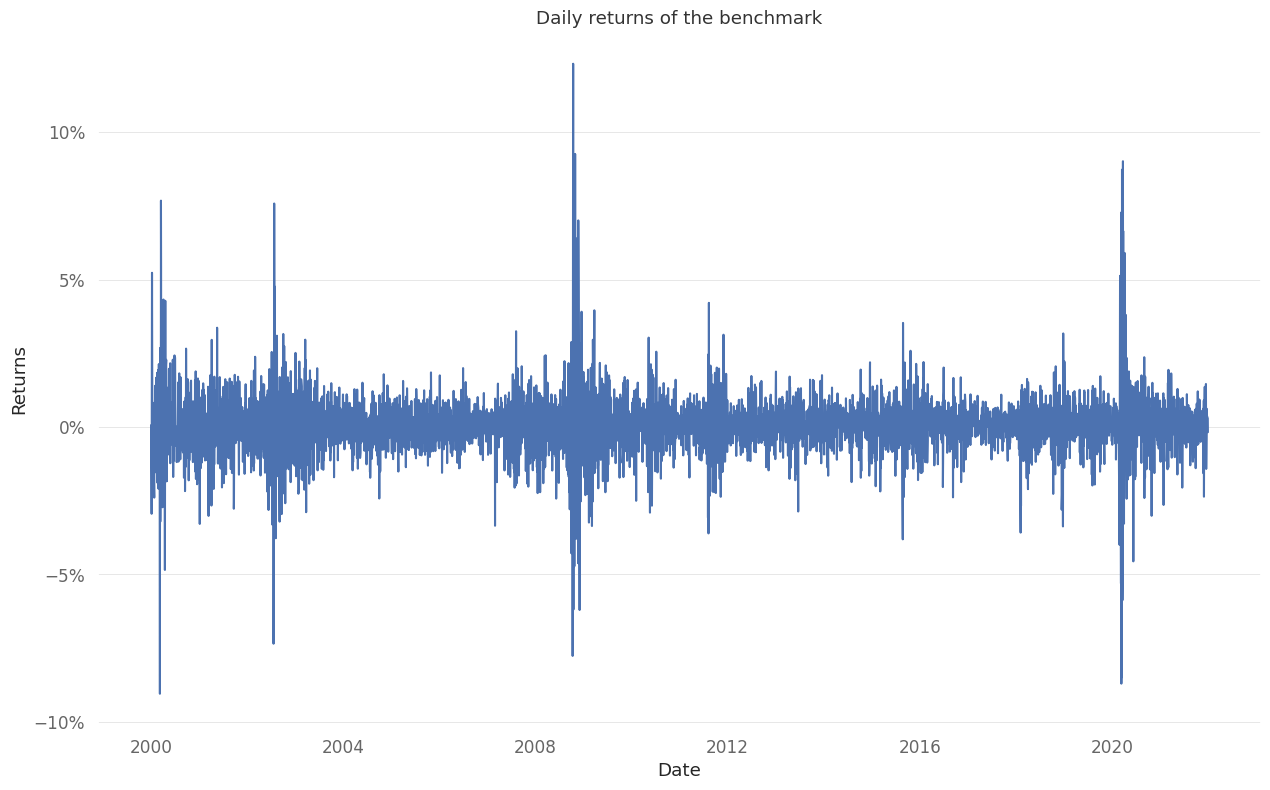

In [21]:
plt.figure(figsize=(15,9))
plt.ylabel("Returns")
plt.xlabel("Date")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
plt.grid(axis="x")
plt.title("Daily returns of the benchmark")
plt.plot(df_bm["ret_bm"]-1)
# plt.savefig("Benchmark.png", format="png", dpi=600, transparent=True)
plt.show()

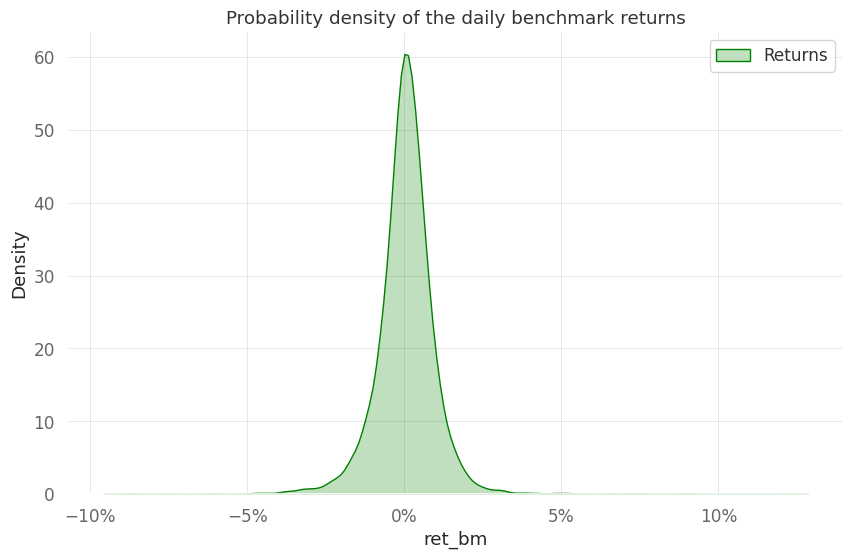

In [22]:
plt.title("Probability density of the daily benchmark returns")
sns.kdeplot(df_bm.ret_bm-1,
            fill = True,
            label = "Returns", color ="green")

plt.legend(loc = "upper right")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

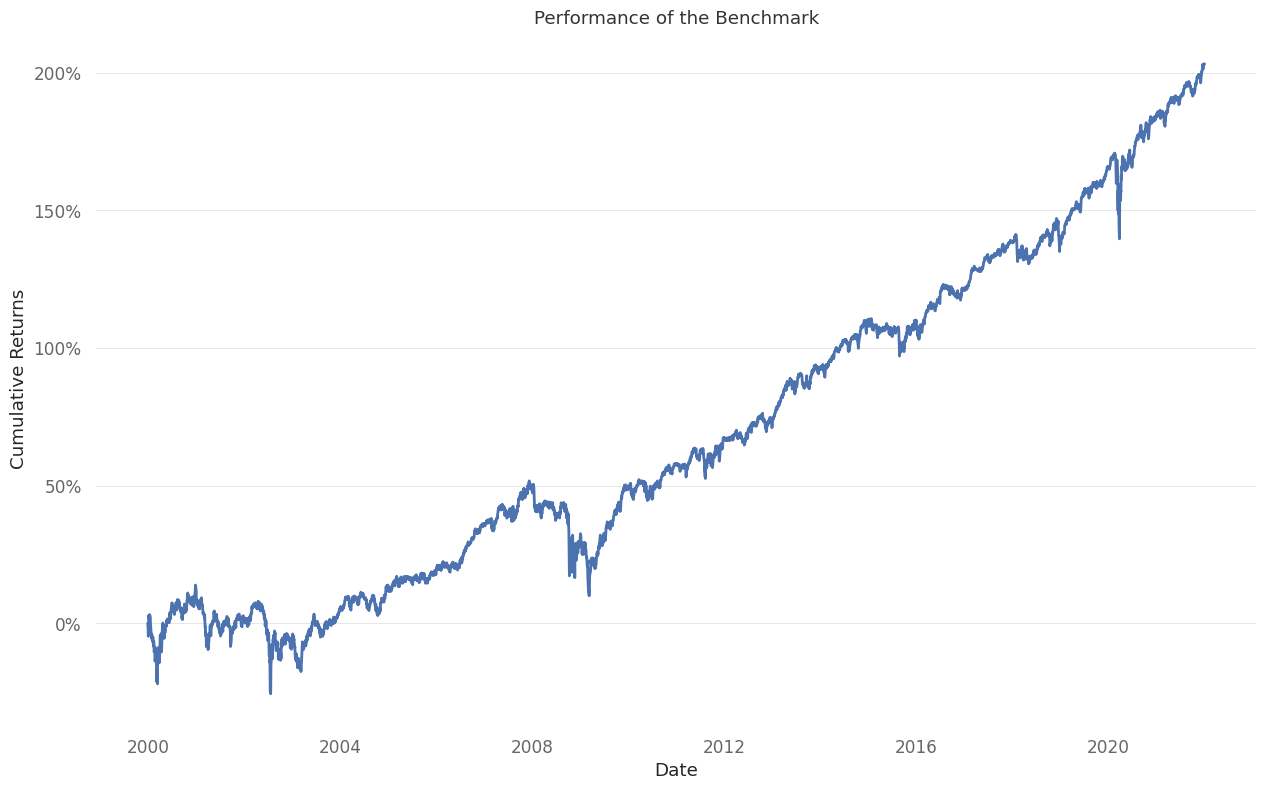

In [23]:
plt.figure(figsize=(15,9))
plt.ylabel("Cumulative Returns")
plt.xlabel("Date")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
plt.grid(axis="x")
plt.title("Performance of the Benchmark")
plt.plot((df_bm.ret_bm.dropna()-1).cumsum(), linewidth = 2)
# plt.savefig("Benchmark.png", format="png", dpi=600, transparent=True)
plt.show()

In [24]:
df.head(3)

ret       mktcap    fret1d    fret5d    mom12m  \
permno  date                                                              
10874.0 2004-04-05  0.013269  3883.782171 -0.002619 -0.021905  1.199157   
        2004-04-06 -0.002619  3935.316000 -0.003581 -0.006923  1.219418   
        2004-04-07 -0.003581  3925.009163 -0.014854  0.004791  1.263542   

                       mom6m     rev1m  beta_mktrf  beta_smb  beta_hml  ...  \
permno  date                                                            ...   
10874.0 2004-04-05  0.442925  0.067887    0.929207  0.021911  0.135846  ...   
        2004-04-06  0.429375  0.039712    0.927334  0.000899  0.078156  ...   
        2004-04-07  0.462696  0.010654    0.924014 -0.019639  0.076406  ...   

                    beta_momsq  iv_atmsq  put_skewsq   call_skewsq  \
permno  date                                                         
10874.0 2004-04-05    0.003112  0.049420    0.001915  1.301082e-04   
        2004-04-06    0.000262  0.050717    0.002573  2.404268e-07   
        2004-04-07    0.000081  0.050339    0.003774  6.784288e-06   

                    iv_atm_put_skew  iv_atm_call_skew  put_skew_call_skew  \
permno  date                                                                
10874.0 2004-04-05         0.009729         -0.002536           -0.000499   
        2004-04-06         0.011423         -0.000110           -0.000025   
        2004-04-07         0.013783         -0.000584           -0.000160   

                    percentage_market_cap  weights  ret_bm  
permno  date                                                
10874.0 2004-04-05               0.341163      NaN     NaN  
        2004-04-06               0.344709      NaN     NaN  
        2004-04-07               0.343095      NaN     NaN  

[3 rows x 45 columns]

In [25]:
df_bm.head()

,ret_bm
date,
1999-12-31,1.000602
2000-01-03,0.982142
2000-01-04,0.970578
2000-01-05,1.003304
2000-01-06,1.019351


In [26]:
df_bm['cumulative_returns'] = (df_bm['ret_bm']).rolling(window=20).apply(lambda x: x.prod(), raw=True) - 1
merged_df_2 = pd.merge(df,df_bm, on=['date'], how='left')
df.reset_index(inplace=True)
df.set_index('date')
df['cum_ret'] = merged_df_2['cumulative_returns'].values
df['cum_fret1d'] = (1 + df["fret1d"]).rolling(window=20).apply(lambda x: x.prod(), raw=True) - 1
df.set_index(['permno', 'date'])

ret        mktcap    fret1d    fret5d    mom12m  \
permno  date                                                               
10874.0 2004-04-05  0.013269   3883.782171 -0.002619 -0.021905  1.199157   
        2004-04-06 -0.002619   3935.316000 -0.003581 -0.006923  1.219418   
        2004-04-07 -0.003581   3925.009163 -0.014854  0.004791  1.263542   
        2004-04-08 -0.014854   3910.954677  0.017510  0.034776  1.352782   
        2004-04-12  0.017510   3852.861660 -0.018164  0.014579  1.390541   
...                      ...           ...       ...       ...       ...   
88664.0 2021-11-12 -0.009233  11788.068107 -0.004691 -0.028718  0.029657   
        2021-11-15 -0.004691  11679.227747  0.004076 -0.024331  0.055661   
        2021-11-16  0.004076  11624.437000 -0.024359 -0.029180  0.059646   
        2021-11-17 -0.024359  11671.823195 -0.013004 -0.006437  0.066143   
        2021-11-18 -0.013004  11387.506026  0.009289 -0.004348  0.093763   

                       mom6m     rev1m  beta_mktrf  beta_smb  beta_hml  ...  \
permno  date                                                            ...   
10874.0 2004-04-05  0.442925  0.067887    0.929207  0.021911  0.135846  ...   
        2004-04-06  0.429375  0.039712    0.927334  0.000899  0.078156  ...   
        2004-04-07  0.462696  0.010654    0.924014 -0.019639  0.076406  ...   
        2004-04-08  0.483999 -0.000486    0.921625 -0.003121  0.085215  ...   
        2004-04-12  0.491957  0.064090    0.924204 -0.002850  0.064028  ...   
...                      ...       ...         ...       ...       ...  ...   
88664.0 2021-11-12  0.059887 -0.060960    0.836499 -0.439657  0.007731  ...   
        2021-11-15  0.063485 -0.076796    0.836389 -0.436316  0.005635  ...   
        2021-11-16  0.061220 -0.078398    0.871926 -0.411568  0.007264  ...   
        2021-11-17  0.049809 -0.100322    0.881072 -0.406322  0.008678  ...   
        2021-11-18  0.035045 -0.112696    0.889982 -0.397461  0.005551  ...   

                    put_skewsq   call_skewsq  iv_atm_put_skew  \
permno  date                                                    
10874.0 2004-04-05    0.001915  1.301082e-04         0.009729   
        2004-04-06    0.002573  2.404268e-07         0.011423   
        2004-04-07    0.003774  6.784288e-06         0.013783   
        2004-04-08    0.006094  3.435895e-04         0.017794   
        2004-04-12    0.003845  6.423690e-06         0.014470   
...                        ...           ...              ...   
88664.0 2021-11-12    0.015729  2.942520e-03         0.029458   
        2021-11-15    0.006121  6.685733e-03         0.018790   
        2021-11-16    0.034458  7.967794e-03         0.044207   
        2021-11-17    0.028697  1.011634e-02         0.040422   
        2021-11-18    0.008946  1.778056e-03         0.023028   

                    iv_atm_call_skew  put_skew_call_skew  \
permno  date                                               
10874.0 2004-04-05         -0.002536           -0.000499   
        2004-04-06         -0.000110           -0.000025   
        2004-04-07         -0.000584           -0.000160   
        2004-04-08          0.004225            0.001447   
        2004-04-12         -0.000591           -0.000157   
...                              ...                 ...   
88664.0 2021-11-12          0.012741            0.006803   
        2021-11-15          0.019638            0.006397   
        2021-11-16          0.021258            0.016570   
        2021-11-17          0.024000            0.017039   
        2021-11-18          0.010266            0.003988   

                    percentage_market_cap   weights    ret_bm   cum_ret  \
permno  date                                                              
10874.0 2004-04-05               0.341163       NaN       NaN -0.000733   
        2004-04-06               0.344709       NaN       NaN  0.004807   
        2004-04-07               0.343095       NaN       NaN  0.008224   
      

In [27]:
#df = df.set_index(['permno', 'date']).sort_index()
bnch_wts=df["weights"]
bnch_wts

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
201072    0.379161
201073    0.379161
201074    0.379161
201075    0.379161
201076    0.379161
Name: weights, Length: 201077, dtype: float64

## <center> 4. Backtesting:

In [28]:
# suppliment functions (all of them are static)
def beta_constraint(wvec,betas, target = 0.5):
    return wvec@betas-target
    
hex(id(beta_constraint))

def winsorize_df(df, feature_names, level_winsorize):
    df = df.copy()
    for ft in feature_names:
        goods    = df[ft].notna()
        df.loc[goods, ft] = winsorize(df.loc[goods,ft], limits=level_winsorize).data
    return df
    
# Apply the maximum absolute scaling in Pandas using the .abs() and .max() methods
def maximum_absolute_scaling(df, columns):
    df = df.copy()
    # apply maximum absolute scaling
    for column in columns:
        df[column ] = df[column]  / df[column].abs().max()
    return df

# apply the min-max scaling in Pandas using the .min() and .max() methods
def min_max_scaling(df, columns):
    df = df.copy()
    # apply min-max scaling
    for column in columns:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())      
    return df

# Apply the Z-score absolute scaling in Pandas using the .abs() and .max() methods
def z_score_scaling(df, columns):
    df = df.copy()
    # apply maximum absolute scaling
    for column in columns:
        df[column] = (df[column] - df[column].mean())  / df[column].abs().max()
    return df

def find_max_corr_feature(df, feature_names_subset, label):
    max_corr = -100000
    var_max = None
    for ft in feature_names_subset:
        cr = np.abs(df[[ft] + [label]].corr()[label].values[0])
        #print(ft + ': ' + str(cr))
        if cr > max_corr:
            max_corr = cr
            var_max = ft
    return var_max

def parse_features(df, feature_names, level_winsorize):
    df = df.copy().dropna()
    for ft in feature_names:
        # winsorise
        df[ft] = winsorize(df[ft], limits=level_winsorize).data

        # apply cox-box transform
        var_norm, lambda_ = stats.boxcox(df[ft] - df[ft].min() +0.0001)
        if lambda_ < 5:
            #print(ft + ': optimal lambda = ' + str(lambda_))
            df[ft] = var_norm
        else:
            print(ft + ' procedure failed, skipping cox box tranformation')
        
        #apply z-score scaling
        df[ft] = (df[ft] - df[ft].mean())  / df[ft].abs().max()
    return df

def forward_selection(df, label, feature_names):
    df = df.copy()
    df['const'] = 1
    feature_names_initial = feature_names.copy()
    feature_names = feature_names.copy()
    rsquared_adj_max = -10000
    ft_selected = []
    for ft in feature_names_initial:
        # find most correlated
        ft_hc = find_max_corr_feature(df, feature_names, label)
        model = sm.OLS(df[label], df[['const'] + ft_selected + [ft_hc]], missing = "drop")
        results = model.fit()
        if results.rsquared_adj > rsquared_adj_max:
            ft_selected.append(ft_hc)
            #print(results.summary())
            #print('Parameters: ', results.params)
            #print('R2_adj: ', results.rsquared_adj)
            feature_names.remove(ft_hc)
            #print(feature_names)
            rsquared_adj_max = results.rsquared_adj
        else:
            prm = {}
            for ft in ft_selected:
                prm[ft] = results.params[ft]
            return prm, rsquared_adj_max
        pass
    prm = {}
    for ft in ft_selected:
        prm[ft] = results.params[ft]
    return prm, rsquared_adj_max

def gramm_schmidt(df, label, feature_names):
    df = df.copy()
    df['const'] = 1
    feature_names_initial = feature_names.copy()
    feature_names = feature_names.copy()
    rsquared_adj_max = -10000
    ft_selected = []
    prm = {}
    for ft in ft_selected:
        prm[ft] = 0
    for ft in feature_names_initial:
        # find most correlated
        ft_hc = find_max_corr_feature(df, feature_names, label)
        y = df[label]
        if len(ft_selected) > 0:
            y = resid
            pass
        model = sm.OLS(y, df[['const'] + [ft_hc]], missing = "drop")
        results = model.fit()
        
        if results.rsquared_adj > rsquared_adj_max:
            ft_selected.append(ft_hc)
            resid = results.resid
            feature_names.remove(ft_hc)
            rsquared_adj_max = results.rsquared_adj
            prm[ft_hc] = results.params[ft_hc]
        else:
            feature_names.remove(ft_hc)
    #         for ft in ft_selected:
    #             if ft in results.params:
    #                 prm[ft] = results.params[ft]
    #         return prm, rsquared_adj_max
    # for ft in ft_selected:
    #     if ft in results.params:
    #         prm[ft] = results.params[ft]
    return prm, rsquared_adj_max

def ridge_regression(df, alpha, label, feature_names):
    #Fit the model
    ridgereg = Ridge(alpha=alpha)
    ridgereg.fit(df[feature_names],df[label])
    y_pred = ridgereg.predict(df[feature_names])
    
    #Return the result in pre-defined format
    rss = sum((y_pred-df[label])**2)
    r_2 = ridgereg.score(df[feature_names],df[label])
    ret = []
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    # print(ridgereg)
    return ret, r_2

def lasso_regression(df,alpha, label, feature_names):
    #Fit the model
    lassoreg = Lasso(alpha=alpha, max_iter=int(1e5))
    lassoreg.fit(df[feature_names],df[label])
    y_pred = lassoreg.predict(df[feature_names])

    #Return the result in pre-defined format
    rss = sum((y_pred-df[label])**2)
    r_2 = lassoreg.score(df[feature_names],df[label])
    ret = []
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    # print(lassoreg)
    return ret, r_2

def apply_LGBM(self, df, label, feature_names):
    params = {
        'objective': 'regression',
        'device': 'cpu',
        'boosting': 'goss',
        # method of boosting (gbdt, rf, dart, goss) --> dart<gbdt<goss ( provides a new sampling method for GBDT by separating those instances with larger gradients)
        'num_iterations': 100,
        'lambda_l1': 20,  # L1 regularization ---> reduces both overfitting and test error
        'lambda_l2': 1,  # L2 regularization
        'max_depth': -1,  # limit the max depth for tree model
        'max_bin': 500,  # Small number of bins may reduce training accuracy but can deal with over-fitting
        'num_leaves': 100,  # max number of leaves in one tree
        'colsample_bytree': 0.8,  # % features used while const tree
        'subsample': 1,  # subsample ratio of the training instance
        'learning_rate': 0.02,
        'metric': 'rmse',
        'verbose': -1  # debugging

    }
    # mdl = lgb.LGBMRegressor(params)
    # loading data
    lgb_train = lgb.Dataset(df[feature_names],
                            df[label])
    # Fit the model
    lgb_model = lgb.train(params,
                            train_set=lgb_train,
                            valid_sets=lgb_train,
                            callbacks=[early_stopping(stopping_rounds=5,verbose = False)]
                            # early_stopping_rounds=5,
                            # verbose_eval = -1
                            )

    y_pred = lgb_model.predict(df[feature_names])

    # Return the result in pre-defined format
    
    r_2 = metrics.r2_score(y_pred, df[label])

    return lgb_model
    
def restrict_trading_universe(df, n_stocks):
    df = df.copy()
    permnos = df.loc[df.date==df.date.max(), ['permno', 'mktcap']].drop_duplicates().\
                sort_values('mktcap', ascending=True)[0:n_stocks]['permno'].values
    return df.loc[df.permno.isin(permnos)]

In [29]:
df = df.reset_index()
df['date'] = pd.to_datetime(df['date'])

In [30]:
def MaxRet(wvec,*args):
     mu = args[1]
     return -wvec@mu

def MVP(wvec,*args):
     cov = args[0]
     var = wvec@cov@wvec
     return var*1e3

def MSR(wvec,*args):
     cov = args[0]
     mu  = args[1]
     sr = mu@wvec/(wvec@cov@wvec)
     return -sr*1e3 

def optimize(cov, mu, fun, cons, bounds):
    N = len(mu)

    res = minimize(fun,
                    np.ones(N)/N,
                    args = (cov, mu), 
                    constraints = cons, 
                    bounds = bounds, 
                    method = 'SLSQP',
                    options={'ftol': 1e-10, 'disp': False})
    return res

def test_strategy_mv(**kwargs):
     cov = kwargs.get('cov')
     NA = cov.shape[0]
     mu = kwargs.get('mu',np.ones(NA))
     ret_fw = kwargs.get('ret_fw',mu)
     method = kwargs.get('method','minvar')
    
     if method == 'minvar':
         w = np.linalg.inv(cov)@np.ones(NA)
         pass
     else:
         w = np.linalg.inv(cov)@mu
         pass
     w = w/np.nansum(w)
    
     return w@ret_fw, w
      

In [31]:
class Backtester:
    dates_rebalance = None
    rolling_frq = None
    df = None
    look_back_prm = None
    n_stocks = None
    optimal_weights = None
    print_results_bool = True
    level_winsorize = None
    
    def __init__(self, 
                 df, 
                 rolling_frw,
                 look_back_prm,
                 n_stocks,
                 level_winsorize,
                 configurations,
                 print_results):
        
        print('Initialising backtester class.. ')
        self.rolling_frq = rolling_frw
        self.df = df
        self.look_back_prm = look_back_prm
        self.n_stocks = n_stocks
        self.configurations=configurations
        self.level_winsorize = level_winsorize
        self.print_results_bool = print_results
        self.dates = []
        self.optimal_weights = {}
        self.returns_strategy = {}
        for key in configurations.keys():
            self.optimal_weights[key] = self.df[['permno', 'date']].copy().set_index(['permno', 'date'])
            self.optimal_weights[key]['weight'] = 0
            self.returns_strategy[key] = self.df[['date']].copy().drop_duplicates().set_index(['date'])
            self.returns_strategy[key]['return'] = None
            self.returns_strategy[key].index = pd.to_datetime(self.returns_strategy[key].index)
        print('..done')

    def make_prediction(self, df_out_sample, prm, model_type = 'linear', features_names= None):
        df_pred = df_out_sample.copy()
        df_pred['pred'] = 0
        const = 0
        if model_type =='linear':
            for ft, prm_ft in prm.items():
                if ft.lower() in ['const', 'constant', 'intercept']:
                    const = prm_ft
                else:
                    df_pred['pred'] += df_pred[ft] * prm_ft
                pass
            df_pred['pred'] += const
            
        else: 
            model = prm
            df_pred['pred'] = model.predict(df_pred[features_names])
        return df_pred

        
    def get_n_days_rolling(self):
        if self.rolling_frq == '1M':
            return 30
        elif self.rolling_frq == '1W':
            return 7
        elif self.rolling_frq == '1D':
            return 1
        else:
            print('rolling_frq not supported: ' + self.rolling_frq)
            
    def parse_data(self, df_r, level_winsorize):
        return parse_features(df_r, feature_names, level_winsorize)
    
    def alpha_estimation(self, df_r, alpha_estimation_method, label, feature_names):
        alpha_estimation_name = alpha_estimation_method['name']
        kwargs = alpha_estimation_method.get('kwargs', {})
        if alpha_estimation_name == 'FrwdSelection':
            prm = self.estimate_forward_selection_method(df_r,label = label, feature_names=feature_names)
        elif alpha_estimation_name == 'RidgeRegression':
            prm = self.estimate_ridge_regression(df_r,label = label, feature_names=feature_names, **kwargs)
        elif alpha_estimation_name == 'LassoRegression':
            prm =self.estimate_lasso_regression(df_r,label = label, feature_names=feature_names, **kwargs)
        elif alpha_estimation_name == 'GrammSchmidt':
            prm = self.estimate_gramm_schmidt(df_r,label = label, feature_names=feature_names)
        elif alpha_estimation_name == 'LGBM':
            prm = self.estimate_LGBM(df_r, label = label, feature_names=feature_names)
        else:
            print('Method is not supported: ' + alpha_estimation_method )
            prm = None
        # print(f'{alpha_estimation_name} {kwargs} optimal parameters: {prm}')
        return prm
    
    def estimate_forward_selection_method(self, df_r,label, feature_names):
        prm, rsquared_adj_max = forward_selection(df_r, label= label,feature_names=feature_names)
        # print('test r_adj = ' + str(rsquared_adj_max))
        #print('optimal model = ' + str(prm)) 
        return prm
    
    def estimate_gramm_schmidt(self, df_r,label, feature_names):
        prm, rsquared_adj_max = gramm_schmidt(df_r, label= label,feature_names=feature_names)
        # print('test r_adj = ' + str(rsquared_adj_max))
        #print('optimal model = ' + str(prm)) 
        return prm
        
    def estimate_ridge_regression(self, df_r,label, feature_names, alpha = 1):
        ft_selected, rsquared_adj_max = ridge_regression(df_r, alpha =alpha, label= label,feature_names=feature_names)
        # print('test r_adj = ' + str(rsquared_adj_max))
        #print('optimal model = ' + str(ft_selected)) 
        # HERE WE HAD A BUG -- ASSIGNED CONSTANT TO A FIRST FEATURE.. ETC. WRONG COEFFICIENTS SAVED FOR ALL FEATURES
        prm = {}
        for i,ft in enumerate(['constant']+feature_names):
            prm[ft] = ft_selected[i]
        return prm
        
    def estimate_lasso_regression(self, df_r, label, feature_names, alpha = 1e-5):
        ft_selected, rsquared_adj_max = lasso_regression(df_r, alpha = alpha, label= label,feature_names=feature_names)
        # print('test r_adj = ' + str(rsquared_adj_max))
        #print('optimal model = ' + str(ft_selected)) 
        # HERE WE HAD A BUG -- ASSIGNED CONSTANT TO A FIRST FEATURE.. ETC. WRONG COEFFICIENTS SAVED FOR ALL FEATURES
        prm = {}
        for i,ft in enumerate(['constant']+feature_names):
            prm[ft] = ft_selected[i]
        return prm

    
    def estimate_LGBM(self, df_r, label , feature_names):
        prm = apply_LGBM(self,df_r, label, feature_names)
        return prm
    
    def prepare_inputs_for_optimisation(self, df_r, df_out_sample, label):   
        #take the list of names that are present in both insample and out of sample datatset
        #we need that to have exactly the same stock that we make prediction for in the out of sample
        permnos = list(set(df_r['permno'].unique()).intersection(df_out_sample['permno'].unique()))
        df_r = df_r[df_r['permno'].isin(permnos)]
        df_out_sample = df_out_sample[df_out_sample['permno'].isin(permnos)]
        
        #rearrange the forward returns to a matrix
        ret = pd.pivot_table(df_r, values=label, index=['date'], columns=['permno'])
        ret = ret.fillna(0.0)
        
        #rearrange the predicted returns to a matrix
        expret = pd.pivot_table(df_out_sample[df_out_sample['permno'].isin(permnos)], 
                                values='pred', index=['date'], columns=['permno'])
        expret = expret.fillna(0.0)
        
        # calculate covariance between returns using insample data
        # in practive we use a risk model here (barrs, axioma)
        r1d = pd.pivot_table(df_r, values='ret', index=['date'], columns=['permno'])
        r1d = r1d.fillna(0.0)
        cov = r1d.cov().values
    
        stock_ids = list(expret.columns)
        
        #we have predicted returns for each day, take the last day in our period
        expret = expret.iloc[0].values
        
        #rearrange realised returns to simplify strategy return calculation
        realised_ret= pd.pivot_table(df_out_sample, values='fret1d', index=['date'], columns=['permno'])
        realised_ret.index = pd.to_datetime(realised_ret.index)
        realised_ret.fillna(0, inplace=True)
        
        #define constraints
        cons = []
        
        N = len(expret)
        
        betas_df = pd.pivot_table(df_out_sample, values='betas', index=['date'], columns=['permno'])   
        
        betas = betas_df.iloc[0,:].values.flatten()
        
        def beta_constraint(wvec,betas, target = 0.5):
            return wvec@betas-target
        
        
        bnch_weights_df = pd.pivot_table(df_out_sample, values='weights', index=['date'], columns=['permno'])
        bnch_weights = bnch_weights_df.iloc[0,:].values.flatten()
        
        def weight_deviation_constraint(wvec, bnch_weights, target =0.1):
            return -(np.abs(wvec-bnch_weights) - target * bnch_weights)
            

        bnch_df = pd.pivot_table(df_out_sample, values='cum_ret', index=['date'], columns=['permno'])
        bnch_ret = bnch_df.iloc[0,:].values.flatten()
        
        portfolio_ret_df = pd.pivot_table(df_out_sample, values='cum_fret1d', index=['date'], columns=['permno'])
        portfolio_ret = bnch_df.iloc[0,:].values.flatten()
        
        def drawdown_constraint(wvec,portfolio_ret,bnch_ret, target=0.01):
            return target-((bnch_ret-(wvec@portfolio_ret))/bnch_ret)
        
        # define constraints
        cons = [ {'type': 'eq', 'fun' : lambda wvec: wvec.sum()-1},
                {'type': 'eq', 'fun' : beta_constraint, 'args': (betas,) },
                {'type': 'ineq', 'fun' : weight_deviation_constraint, 'args': (bnch_weights,)},
                {'type': 'ineq', 'fun' : drawdown_constraint, 'args': (portfolio_ret,bnch_ret,)} ] 
        
        # define bounds
        bounds = [[-0.25, 0.25] for z in range(N)]
        
        return cov, expret, realised_ret, cons, bounds, stock_ids, betas_df

    def print_results(self):
        # descriptive stats of performance
        for run_name, cfg in self.configurations.items():
            print('Analysis of the result for configuration: ' + run_name)
            ret = self.returns_strategy[run_name].dropna()
            ret.cumsum().plot()
            print('Sharpe ratio = ' + str(ret['return'].mean()/ret['return'].std()*np.sqrt(252)))
            print('Annual return = ' + str(ret['return'].sum()))
            print('Average daily return (bps)= ' + str(ret['return'].mean()* 1e4))
            qs.reports.full(ret['return'])
            print('****************************************')


    def backtest(self,dt):
        print('for date: ' + str(dt))
        returns_strategy = pd.DataFrame(columns= self.configurations.keys())
        optimal_weights = {}
        # for key in configurations.keys():
        #     returns_strategy[key] = self.df[['date']].copy().drop_duplicates().set_index(['date'])
        for cfg_name, cfg in self.configurations.items():
            # print('processing configuration: ' + cfg_name)
            model_type = cfg['model_type']
            #############################################
            ### ASSIGN CONFIGURATION PARAMETERS #########
            last_day_shift = cfg.get('last_day_shift', 5)
            label = cfg.get('label', 'fret5d')
            features = cfg.get('features', None)
            alpha_estimation_method = cfg['alpha_estimation_method']
            parsing_pipe = cfg.get('parsing',None)
            model_type = cfg.get('model_type',"linear")
            #############################################
            if features is None: 
                print(f'No features specified for {cfg_name}')
                break

            # step0: restrict universe to speed up calculations (remove later):
            df = restrict_trading_universe(self.df, self.n_stocks)

            # step1: restrict dataset to insample
            ######
                #please note the change to the first version - we shifted the dates by 5 days to avoid look ahead bias
            #####
            # print('step1: restrict dataset to insample')
            df_r = df.loc[np.logical_and(
                df['date'] >= dt - pd.Timedelta(days=self.look_back_prm), 
                df['date'] < dt - pd.Timedelta(days = last_day_shift)), :].copy()
            # print('       insample period, start date: ' + 
            #       str(df_r['date'].min()) + 
            #       ' end date = ' + 
            #       str(df_r['date'].max()))

            # step2: prepare data - filter out outlier, normalise, winsorise, cox-box trasnform
            # print('step2: prepare data in-sample')
            if parsing_pipe is not None: 
                df_r[features] = parsing_pipe.fit_transform(df_r[features])
            else:
                df_r = self.parse_data(df_r, self.level_winsorize)

            # step3: run alpha estimation method
            # print(f'step3: run alpha estimation method: {alpha_estimation_method}')
            prm = self.alpha_estimation(df_r, 
                                        alpha_estimation_method=alpha_estimation_method, 
                                        label=label, 
                                        feature_names = features)

            # step4: set out of sample period 
            # print('step4: set out of sample period')
            sel = np.logical_and(
                df['date'] >= dt, 
                df['date'] < dt + pd.Timedelta(days=self.get_n_days_rolling()))
            if sum(sel)==0:
                continue
                
            df_out_sample = df.loc[sel, :].copy()
            # print('       out of sample period, start date: ' + 
            #       str(df_out_sample['date'].min()) + 
            #       ' end date = ' + 
            #       str(df_out_sample['date'].max()))

            # step5: prepare out of data (only factors!) 
            # - filter out outlier, normalise, winsorize, cox-box transform
            # print('step5: prepare out of data (only factors!)')
            if parsing_pipe is not None:
                df_out_sample[features] = parsing_pipe.transform(df_out_sample[features])
            else: 
                df_out_sample = self.parse_data(df_out_sample, self.level_winsorize)

            #step6: make prediction for out of sample
            # print('step6: make prediction for out of sample')
            df_pred = self.make_prediction(df_out_sample, prm, model_type = model_type,features_names=features)
            #print(df_pred.head())

            #step7: estimate covarinace and prepare inputs for optimisation
            # print('    step7: estimate covariance and prepare inputs for optimisation')
            cov, expret, realised_ret, cons, bounds, stock_ids, betas_df = \
                self.prepare_inputs_for_optimisation(df_r, df_pred, label = label)
            
            #step8: solve optimisation problem
            # print('    step8: solve optimisation problem')
            res = optimize(cov, expret, cfg['opt_function'], cons, bounds)
            # res.x are the optimal weight that we were looking for....
            # for d in pd.date_range(dt, dt + pd.Timedelta(days=self.get_n_days_rolling()-1)):
            #     self.optimal_weights[cfg_name].loc[d, stock_ids] = res.x
            #     if d in realised_ret.index:
            #         self.returns_strategy[cfg_name].loc[d] = res.x@realised_ret.loc[d]
            #         print(f'realized betas for {d}: {res.x@betas_df.loc[d]}')
                    
            for d in pd.date_range(dt, dt + pd.Timedelta(days=self.get_n_days_rolling()-1)):
                # optimal_weights[cfg_name].loc[d, stock_ids] = res.x

                if d in realised_ret.index:
                    # returns_strategy.loc[d,cfg_name] = np.nansum(res.x.T*realised_ret.loc[d])
                    # returns_strategy.loc[d,cfg_name] = np.dot(res.x,realised_ret.loc[d])
                    returns_strategy.loc[d,cfg_name] = res.x@realised_ret.loc[d]
                    
                    # print(f'realized betas for {d}: {res.x@betas_df.loc[d]}')
            # for d in pd.date_range(dt, dt + pd.Timedelta(days=self.get_n_days_rolling()-1)):
            #     optimal_weights[cfg_name].loc[d, stock_ids] = res.x
            #     if d in realised_ret.index:
            #         returns_strategy[cfg_name].loc[d] = res.x@realised_ret.loc[d]
            #         print(f'realized betas for {d}: {res.x@betas_df.loc[d]}')
        return returns_strategy


    def run_backtest_parallel(self):
        print('running backtest parallel...')
        results = []
        dt_list = pd.date_range(start=self.df['date'].min() + pd.Timedelta(days=self.look_back_prm),
                                end=self.df['date'].max() - pd.Timedelta(days=self.get_n_days_rolling()+1), 
                                freq=self.rolling_frq)

        with Parallel(n_jobs=CPUUsed) as parallel:
            results  = parallel(delayed(self.backtest)(dt) for dt in dt_list)
        
        bk_results = pd.concat(results)
        for col in bk_results.columns:
            bk_results[col] = pd.to_numeric(bk_results[col])
        return bk_results

## Backtest Testing functions:
    def test_function(self,dt):
        res = pd.DataFrame(columns= self.configurations.keys())
        for key in self.configurations.keys():
            res.loc[dt,key] = 1
        return(res)


    def run_backtest_parallel_test(self):
        print('running backtest parallel...')
        results = []
        dt_list = pd.date_range(start=self.df['date'].min() + pd.Timedelta(days=self.look_back_prm),
                                end=self.df['date'].max() - pd.Timedelta(days=self.get_n_days_rolling()+1), 
                                freq=self.rolling_frq)
        with Parallel(n_jobs=CPUUsed) as parallel:
            results  = parallel(delayed(self.test_function)(dt) for dt in dt_list)
        
        return pd.concat(results)

In [32]:
df.columns

Index(['index', 'permno', 'date', 'ret', 'mktcap', 'fret1d', 'fret5d',
       'mom12m', 'mom6m', 'rev1m', 'beta_mktrf', 'beta_smb', 'beta_hml',
       'beta_mom', 'idvar_ff4', 'secid', 'iv_atm', 'put_skew', 'call_skew',
       'skew', 'glb2_D30', 'glb3_D30', 'glb2_D91', 'glb3_D91', 'glb2_D182',
       'glb3_D182', 'glb2_D273', 'glb3_D273', 'glb2_D365', 'glb3_D365',
       'constant', 'betas', 'mom12msq', 'mom6msq', 'rev1msq', 'beta_mktrfsq',
       'beta_smbsq', 'beta_hmlsq', 'beta_momsq', 'iv_atmsq', 'put_skewsq',
       'call_skewsq', 'iv_atm_put_skew', 'iv_atm_call_skew',
       'put_skew_call_skew', 'percentage_market_cap', 'weights', 'ret_bm',
       'cum_ret', 'cum_fret1d'],
      dtype='object')

### <center> Configurations:

In [33]:
# Beta column for the constraint function
features = feature_names[:-1] + feature_sq + feature_combo + features_glb #+ feature_bv_betas
features

# pipeqt = Pipeline([('ws',Winsorize(level_winsorize = 0.01)),
#                 ('qt',QuantileTransformer(output_distribution='uniform',n_quantiles=100)),
#                 ('maxabs',MaxAbsScaler())])

pipept = Pipeline([('ws',Winsorize(level_winsorize = 0.01)),
                ('qt',PowerTransformer()),
                ('maxabs',MaxAbsScaler())])

configurations = {
                    'MVP_GrammSchmidt': {'opt_function': MVP,
                                        'alpha_estimation_method':{'name':'GrammSchmidt'},
                                        'label':'fret5d',
                                        'last_day_shift':5, 
                                        'features': features,
                                        'model_type':'linear'},
                    'MVP_FrwrdSelection': {'opt_function': MVP,
                                        'alpha_estimation_method': {'name': 'FrwdSelection'},
                                        'label':'fret5d',
                                        'last_day_shift':5,
                                        'features':features,
                                        'model_type':'linear',
                                        'parsing':clone(pipept)},
                    'MVP_LASSO': {'opt_function': MVP,
                                        'alpha_estimation_method':{'name':'LassoRegression', 'kwargs':{'alpha':0.01}},
                                        'label':'fret5d',
                                        'last_day_shift':5, 
                                        'features': features,
                                        'model_type':'linear',
                                        'parsing':clone(pipept)},
                    'MVP_RIDGE': {'opt_function': MVP,
                                        'alpha_estimation_method':{'name':'RidgeRegression', 'kwargs':{'alpha':1}},
                                        'label':'fret5d',
                                        'last_day_shift':5, 
                                        'features': features,
                                        'model_type':'linear',
                                        'parsing':clone(pipept)},                          
                    'MVP_LGBM': {'opt_function': MVP,
                                        'alpha_estimation_method':{'name':'LGBM'},
                                        'label':'fret5d',
                                        'last_day_shift':5, 
                                        'features': features,
                                        'model_type':'Non_linear'},

                    'MSR_FrwdSelection': {'opt_function': MSR,
                                        'alpha_estimation_method':{'name':'FrwdSelection'},
                                       'label':'fret5d',
                                       'last_day_shift':5, 
                                       'features': features,
                                       'model_type':'linear'},
                                       
                    'MSR_GrammSchmidt': {'opt_function': MSR,
                                        'alpha_estimation_method':{'name':'GrammSchmidt'},
                                       'label':'fret5d',
                                       'last_day_shift':5, 
                                       'features': features,
                                       'model_type':'linear'}, 
                    'MSR_LASSO': {'opt_function': MSR,
                                        'alpha_estimation_method':{'name':'LassoRegression', 'kwargs':{'alpha':0.01}},
                                        'label':'fret5d',
                                        'last_day_shift':5, 
                                        'features': features,
                                        'model_type':'linear'},
                    'MSR_RIDGE': {'opt_function': MSR,
                                        'alpha_estimation_method':{'name':'RidgeRegression', 'kwargs':{'alpha':1}},
                                        'label':'fret5d',
                                        'last_day_shift':5, 
                                        'features': features,
                                        'model_type':'linear'},
                    'MSR_LGBM': {'opt_function': MSR,
                                        'alpha_estimation_method':{'name':'LGBM'},
                                        'label':'fret5d',
                                        'last_day_shift':5, 
                                        'features': features,
                                        'model_type':'Non_linear'},

                    'MaxRet_FrwrdSelection': {'opt_function': MaxRet,
                                        'alpha_estimation_method': {'name': 'FrwdSelection'},
                                        'label':'fret5d',
                                        'last_day_shift':5,
                                        'model_type':'linear',
                                        'features':features},
                    'MaxRet_GrammSchmidt': {'opt_function': MaxRet,
                                        'alpha_estimation_method':{'name':'GrammSchmidt'},
                                        'label':'fret5d',
                                        'last_day_shift':5, 
                                        'model_type':'linear',
                                        'features': features}, 
                    'MaxRet_LASSO': {'opt_function': MaxRet,
                                        'alpha_estimation_method':{'name':'LassoRegression', 'kwargs':{'alpha':0.01}},
                                        'label':'fret5d',
                                        'last_day_shift':5,
                                        'model_type':'linear', 
                                        'features': features},
                    'MaxRet_RIDGE': {'opt_function': MaxRet,
                                        'alpha_estimation_method':{'name':'RidgeRegression', 'kwargs':{'alpha':1}},
                                        'label':'fret5d',
                                        'last_day_shift':5, 
                                        'model_type':'linear',
                                        'features': features},
                    'MaxRet_LGBM': {'opt_function': MaxRet,
                                        'alpha_estimation_method':{'name':'LGBM'},
                                        'label':'fret5d',
                                        'last_day_shift':5, 
                                        'features': features,
                                        'model_type':'Non_linear'},

}


Let's have a final look at all the features that will be used:

In [34]:
features

['mom12m',
 'mom6m',
 'rev1m',
 'beta_mktrf',
 'beta_smb',
 'beta_hml',
 'beta_mom',
 'idvar_ff4',
 'iv_atm',
 'put_skew',
 'call_skew',
 'mom12msq',
 'mom6msq',
 'rev1msq',
 'beta_mktrfsq',
 'beta_smbsq',
 'beta_hmlsq',
 'beta_momsq',
 'iv_atmsq',
 'put_skewsq',
 'call_skewsq',
 'iv_atm_put_skew',
 'iv_atm_call_skew',
 'put_skew_call_skew',
 'glb2_D30',
 'glb3_D30',
 'glb2_D91',
 'glb3_D91',
 'glb2_D182',
 'glb3_D182',
 'glb2_D273',
 'glb3_D273',
 'glb2_D365',
 'glb3_D365']

In [35]:
### Run only 1 loop of the backtest:
rolling_frq = '1W'
look_back_prm = 2*365
dt_list = pd.date_range(start=df['date'].min() + pd.Timedelta(days=look_back_prm),
                                end=df['date'].max() - pd.Timedelta(days=7+1), 
                                freq=rolling_frq)

dt = dt_list[0]
bk_SC_config = Backtester(df=df[df.date <'2005-01-01'],
                rolling_frw = '1W',
                look_back_prm = 2*365,
                n_stocks = 50,
                level_winsorize = 0.001, # changing parameter to 0.01 for testing purposes.
                configurations = configurations,
                print_results=False)
bk_SC_config.backtest(dt)

Initialising backtester class.. 
..done
for date: 2001-12-30 00:00:00


,MVP_GrammSchmidt,MVP_FrwrdSelection,MVP_LASSO,MVP_RIDGE,MVP_LGBM,MSR_FrwdSelection,MSR_GrammSchmidt,MSR_LASSO,MSR_RIDGE,MSR_LGBM,MaxRet_FrwrdSelection,MaxRet_GrammSchmidt,MaxRet_LASSO,MaxRet_RIDGE,MaxRet_LGBM
2001-12-31,0.012263,0.012263,0.012263,0.012263,0.012263,0.012281,0.012263,0.012263,0.009033,0.012263,0.012263,0.012263,0.012263,0.012263,0.012263
2002-01-02,0.019151,0.019151,0.019151,0.019151,0.019151,0.019163,0.019151,0.019151,0.009178,0.019151,0.019151,0.019151,0.019151,0.019151,0.019151
2002-01-03,0.00125,0.00125,0.00125,0.00125,0.00125,0.001249,0.00125,0.00125,0.000588,0.00125,0.00125,0.00125,0.00125,0.00125,0.00125
2002-01-04,-0.008275,-0.008275,-0.008275,-0.008275,-0.008275,-0.008282,-0.008275,-0.008275,-0.005128,-0.008275,-0.008275,-0.008275,-0.008275,-0.008275,-0.008275


### Training set:

In [36]:
# bk.print_results()
%time
%load_ext autoreload
%autoreload 2
start_time = time.time()
bk_train = Backtester(df=df[df.date <'2016-01-01'],
                rolling_frw = '1W',
                look_back_prm = 2*365,
                n_stocks = 50,
                level_winsorize = 0.01, # changing parameter to 0.01 for testing purposes.
                configurations = configurations,
                print_results=False)
res_train = bk_train.run_backtest_parallel()
end_time = time.time()
clear_output()
print("time taken {} mins".format((end_time - start_time)/60))

time taken 12.491616070270538 mins


In [37]:
res_train.head()

,MVP_GrammSchmidt,MVP_FrwrdSelection,MVP_LASSO,MVP_RIDGE,MVP_LGBM,MSR_FrwdSelection,MSR_GrammSchmidt,MSR_LASSO,MSR_RIDGE,MSR_LGBM,MaxRet_FrwrdSelection,MaxRet_GrammSchmidt,MaxRet_LASSO,MaxRet_RIDGE,MaxRet_LGBM
2001-12-31,0.013295,0.013295,0.013295,0.013295,0.013295,0.013295,0.013295,0.013295,0.013295,0.013295,0.013295,0.013295,0.013295,0.013295,0.013295
2002-01-02,0.022345,0.022345,0.022345,0.022345,0.022345,0.022345,0.022345,0.022345,0.022345,0.022345,0.022345,0.022345,0.022345,0.022345,0.022345
2002-01-03,0.001428,0.001428,0.001428,0.001428,0.001428,0.001428,0.001428,0.001428,0.001428,0.001428,0.001428,0.001428,0.001428,0.001428,0.001428
2002-01-04,-0.008101,-0.008101,-0.008101,-0.008101,-0.008101,-0.008101,-0.008101,-0.008101,-0.008101,-0.008101,-0.008101,-0.008101,-0.008101,-0.008101,-0.008101
2002-01-07,-0.003450,-0.003450,-0.003450,-0.003450,-0.003450,-0.003450,-0.003450,-0.003450,-0.003450,-0.003451,-0.003450,-0.003450,-0.003450,-0.003450,-0.003450


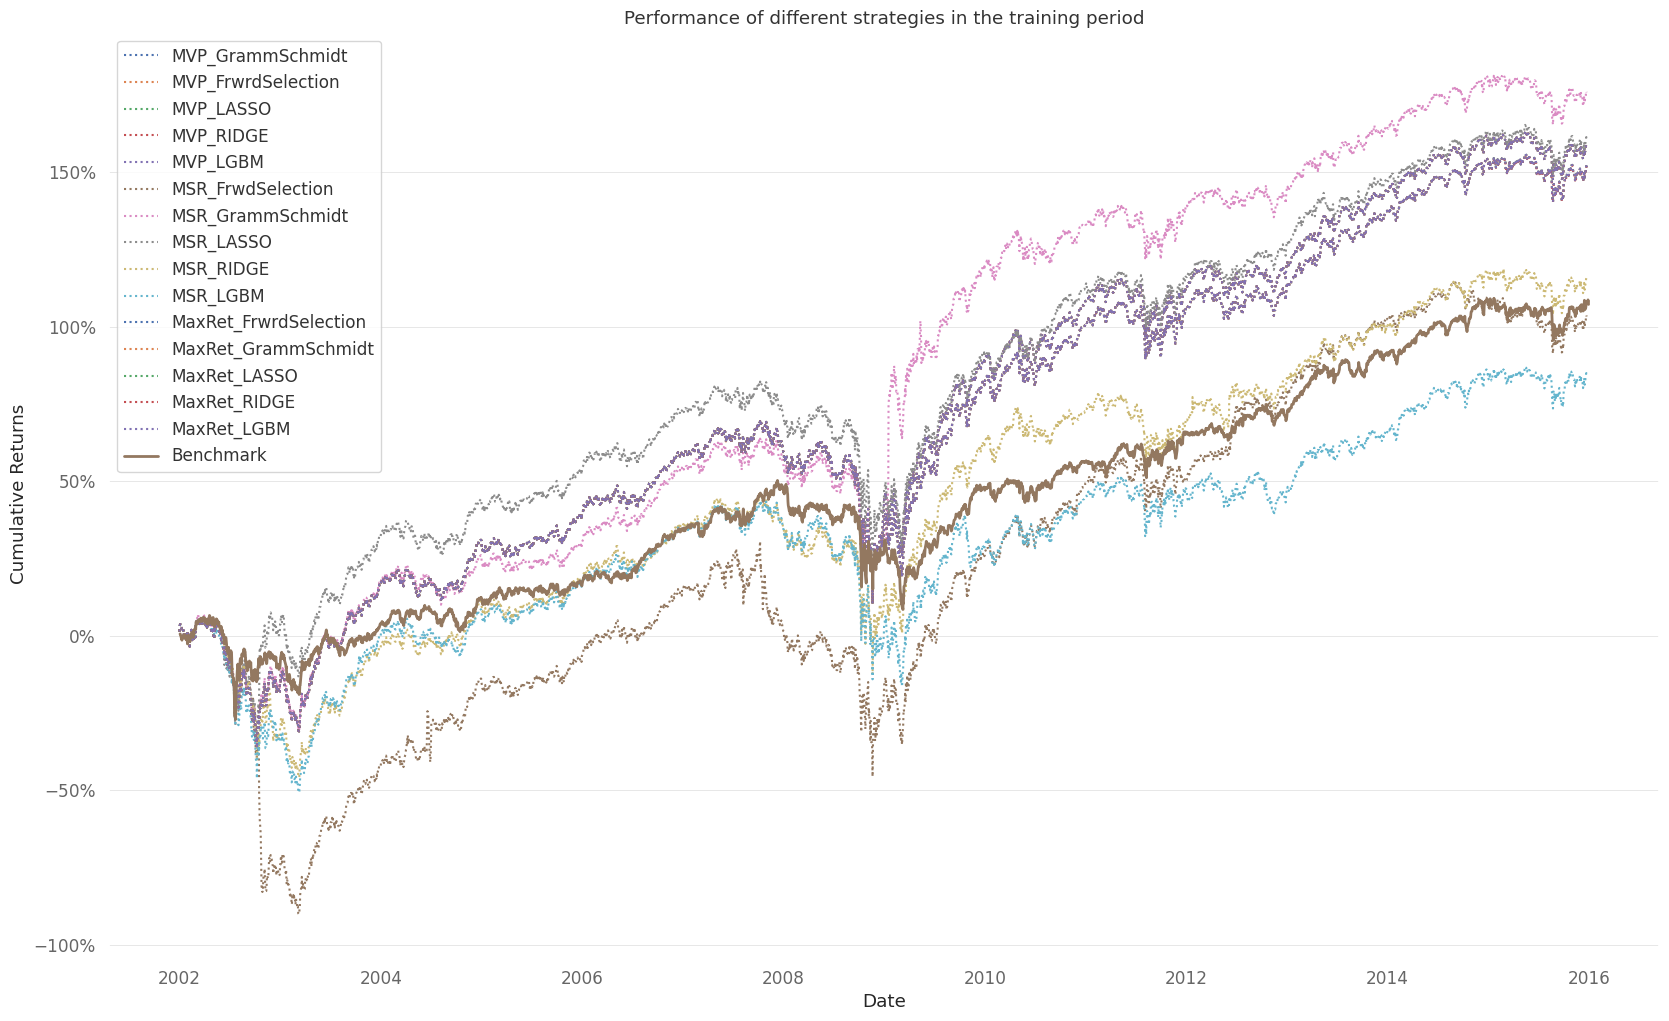

In [38]:
plt.figure(figsize=(20,12))
plt.ylabel("Cumulative Returns")
plt.xlabel("Date")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
plt.grid(axis="x")
plt.title("Performance of different strategies in the training period")
plt.plot(res_train.dropna().cumsum(), linestyle = 'dotted')
plt.plot((df_bm[(df_bm.index >= "2002-01-01") & (df_bm.index < "2016-01-01")]["ret_bm"]-1).cumsum(), linewidth = 2)
x = list(res_train.columns)
x+=(["Benchmark"])

plt.legend(x)
# plt.savefig("Training_all.png", format="png", dpi=600, transparent=True)
plt.show()

In [39]:
# plot_returns(res_train)
return_stats(res_train)
# return_stats(res_train).to_csv("return_stats_train.csv", mode = "w")

,Total Returns,Sharpe Ratio
MVP_GrammSchmidt,1.586779,0.589436
MVP_FrwrdSelection,1.586779,0.589436
MVP_LASSO,1.586779,0.589436
MVP_RIDGE,1.586779,0.589436
MVP_LGBM,1.586779,0.589436
MSR_FrwdSelection,1.032530,0.354398
MSR_GrammSchmidt,1.757943,0.620310
MSR_LASSO,1.609257,0.584025
MSR_RIDGE,1.152890,0.427947
MSR_LGBM,0.845593,0.317555


### <center> Picking the 3 best strategy for testing period (2016-2021):

In [40]:
training_results = res_train.mean()/res_train.std()*np.sqrt(252)
# best_strategy = {training_results.idxmax() : configurations[training_results.idxmax()]}
best_strategy = {}
for i in range(1,4):
    best_strategy.update({training_results.nlargest(i)[-1:].index[0] : configurations[training_results.nlargest(i)[-1:].index[0]]})

%time
%load_ext autoreload
%autoreload 2
start_time = time.time()
# Remember that the beginning data will be missing in the results as it will be used for the rolling window
bk_test = Backtester(df=df[df.date >='2014-01-01'],
                rolling_frw = '1W',
                look_back_prm = 2*365,
                n_stocks = 50,
                level_winsorize = 0.01, # changing parameter to 0.01 for testing purposes.
                configurations = best_strategy,
                print_results=False)
res_test = bk_test.run_backtest_parallel()
end_time = time.time()
clear_output()
print("time taken {} mins".format((end_time - start_time)/60))

time taken 1.055248463153839 mins


In [41]:
res_test.head()

,MSR_GrammSchmidt,MVP_GrammSchmidt,MVP_LGBM
2016-01-04,0.000727,0.000727,0.000727
2016-01-05,-0.012539,-0.012539,-0.012539
2016-01-06,-0.021161,-0.021161,-0.021161
2016-01-07,-0.010922,-0.010922,-0.010922
2016-01-08,-0.000140,-0.000140,-0.000140


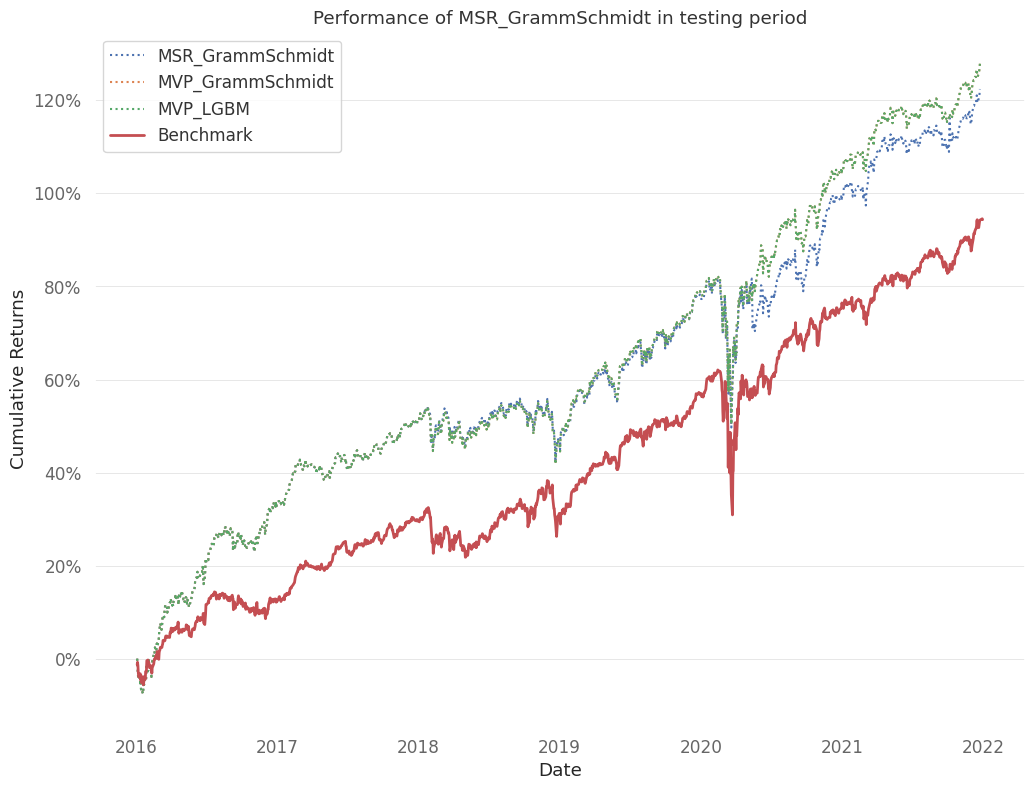

In [42]:
import matplotlib.ticker as mtick
plt.figure(figsize=(12,9))
plt.ylabel("Cumulative Returns")
plt.xlabel("Date")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
plt.grid(axis="x")
plt.title("Performance of {} in testing period".format(training_results.idxmax()))
plt.plot(res_test.dropna().cumsum(), linestyle = 'dotted')
plt.plot((df_bm[(df_bm.index >= "2016-01-01")]["ret_bm"]-1).cumsum(), linewidth = 2)
x = list(res_test.columns)
x+=(["Benchmark"])

plt.legend(x)
# plt.savefig("training.png", format="png", dpi=600, transparent=True)
plt.show()

In [43]:
# plot_returns(res_test)
return_stats(res_test)
# return_stats(res_test).to_csv("return_stats_test.csv", mode = "w")

,Total Returns,Sharpe Ratio
MSR_GrammSchmidt,1.224073,1.156896
MVP_GrammSchmidt,1.278283,1.245387
MVP_LGBM,1.278283,1.245387
Benchmark,0.942428,0.998918


Printing the stats using quantstats:

In [44]:
# print_results(res_test)

### Saving the results to excel:

In [45]:
# create a excel writer object
with pd.ExcelWriter("final_results.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    return_stats(res_train).to_excel(writer, sheet_name="Training_results", index=True)
    return_stats(res_test).to_excel(writer, sheet_name="Testing_results", index=True)
    res_train.to_excel(writer, sheet_name="Training", index=True)
    res_test.to_excel(writer, sheet_name="Testing", index=True)
